# 'Attention Is All You Need' Paper Review

In this notebook, I will walk through the seminal paper _'Attention Is All You Need'_ by Vaswani et al. where the original *Transformer* model is introduced, including code and in depth explanations of the mechanisms where warranted. This paper and the attention mechanism introduced has had far reaching effects in many fields of Deep Learning, but none moreso than Natural Language Processing. The Transformer and its variants are de facto state-of-the-art on many tasks now, with the attention mechanism making jumps to other fields as well, such as with the [_'Self-Attention Generative Adversarial Networks'_](https://arxiv.org/abs/1805.08318) of Zhang, Goodfellow et al. Follow along with the original paper [here](https://arxiv.org/abs/1706.03762). I originally began this process for my own benefit, as this is similar to my method of taking notes anyways and realized it may be of help to others as well, so feel free to peruse. If you wish to find more notebooks like this, visit [my github](https://github.com/jacobhutchinson/).

I am going to be walking through some of the finer details of the code for Transformer, leaving some of the specifics and implementation details for the model training to you all, which I will cover in notes below as well. This will not be a complete Transformer model, look to the links below for complete, runnable models. It should also be noted that I have referenced code from three sources liberally throughout:
- The implementation from the original paper, available [here](https://github.com/tensorflow/tensor2tensor)
- The code from the paper breakdown by Harvard's NLP team [here](http://nlp.seas.harvard.edu/2018/04/03/attention.html). Frankly, if you want to skip the in-depth mechanics discussion and get right to more in-depth code, skip my notebook here and go to this link instead. They do a phenomenal job and have some good visualizations.
- The annotated Transformers implementation from LabML available from their website [here](https://nn.labml.ai/). If you want line-by-line annotations and explanations of code, they do a phenomenal job as well.

Finally, if the concepts here are too in-depth or I fail to provide enough context for you, reading the beautifully animated article [_The Illustrated Transformer_](http://jalammar.github.io/illustrated-transformer/) by Jay Alammar will likely help things to click into place.

With that out of the way, let's import some libraries before we jump into the paper. As you can probably guess, all code here will be in Python and I will be using PyTorch throughout.

In [59]:
import math
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline


## 1. Introduction

The authors point out in this section that various Recurrent Neural Networks (RNN), specifically the Long Short Term Memory (LSTM) Model and Gated Recurrent Unit (GRU) models have been state-of-the-art (SOTA) for a very long time in sequence modeling and other Natural Language Processing problems. Specifically, encoder-decoder RNN structures have been the go-to for sequence-to-sequence models for years now. The authors then bring up two facts:

- The sequential nature of these models have the downside of precluding all attempts at parallelization due to their very nature, despite recent improvements in computation efficiency.
- The attention mechanism has become an integral part of these models for various tasks, allowing for the models to focus on specific parts of an input or output without regard to how their distance from the current position.

They then go on to say that their newly proposed Transformer model does away with the recursion found in a traditional RNN, instead building their entire model around the attention mechanism and using it alone to model global dependencies between the input and output. This new model allows for "significantly more parallelization and can reach a new state of the art in translation quality after being trained for as little as twelve hours on eight P100 GPUs". Even in a field as fast moving as that of deep learning, this kind of leap forward was almost unheard of at the time.

## 2. Background

In this section, the authors begin by pointing to several other architectures that similarly focused on "reducing sequential computation", specifically the Extended Neural GPU, ByteNet and ConvS2S. These nets are all formed from convolutional networks as basic building blocks, with hidden representations being able to be computed in parallel for all input and output positions, but with computations increasing with the distance between inputs and output dependency positions, leading to a challenging time learning dependencies between distant positions. In the Transformer, this computation time is fixed for any input or output position dependency. They mention the downside is a decreased 'resolution' in dependencies due to an averaging of the attention-weighted positions, which is counteracted by their Multi-Headed Attention mechanism which we will describe later.

The authors then bring up similar ideas in different models, including Self-Attention or intra-attention models which focus on using attention mapping of the input sequence to represent the sequence and end-to-end memory networks which use a recurrent attention mechanism in place of sequence aligned recurrence typically found in an RNN. They then point out that to their knowledge, the Transformer is the "first transduction model relying entirely on self-attention to compute representations of its input and output without using sequence aligned RNNs or convolution." 

## 3. Model Architecture

Here, the authors point out that their model follows the overall architecture of an encoder-decoder model, where symbols (read: words, letters, etc...) are absorbed as input, continuous variables are passed as the output of the encoder to the input of the decoder, wherein they are translated back into symbols, or more accurately, as probabilities of symbols. The following picture is from the paper, showing the Encoder on the left and the Decoder on the right:

<img src="images/1BHzGVskWGS_3jEcYYi6miQ.png" width="500" align = "center" />

### 3.1 Encoder and Decoder Stacks

**Encoder:** For the Encoder side of the model, the architecture the authors chose is $N=6$ identical layers, each one formed as seen above in the grey box on the left, with a _Multi-Head Attention_ sub-layer followed by a _Position-Wise fully connected feed-forward network_. Both of these will be described in more detail (and code) below. Of course, in practice the value of $N$ is a hyperparmeter that can vary. Each layer has a _residual connection_, also called a _skip connection_, which is used commonly to allow gradients to travel from the beginning to the end of a network without passing through each non-linear activation function. If a gradient flows through the network through many non-linear activation functions that gradient is likely to explode, or increase in size vastly, or vanish and become very small due to the nature of the non-linear activation. DUe to the nature of these _residual connections_ and some upcoming math, all sub-layers in the model, as well as the embedding layers, must all have the same dimension. For this, the authors chose $d_{\text{model}}=512$.

Instead, these _residual connections_ have a 'bus' running from the beginning to the end of the network, allowing 'blocks' of code to pull the gradients off the bus and add them back onto it afterwards. That is what happens here with both the _Multi-Head Attention_ block of code and the _Position-Wise fully connected feed-forward network_ block of code, where gradients are added back and then layer normalization is performed after each block. The paper describes the output of each sub-layer as $\text{LayerNorm}(x+\text{Sublayer}(x))$.

**Decoder:** Similar to the encoder, the decoder side of the model is composed of $N=6$ identical layers of the grey box on the right above. In addition to the sub-layers from the encoder model, they also add a multi-head attention sub-slayer focused on the output passed in from the encoder stack. On top of this, the first multi-head attention sub-layer is _masked_, which means that it is modified to "prevent positions from attending to subsequent positions". This, combined with the shifting of the output embedding one to the right guarantees the predictions for position $i$ depend only on the known outputs at positions less than $i$. More on this layer. After each on the sub layers, _residual connections_ are once again used and layer normalization is performed.

The Encoder and Decoder will be left for the reader to put together, although I will prvide all the building blocks needed to form either.

### 3.2 Attention

The authors here describe attention functions as a mapping of a query and a set of key-value pairs to an output, where the query, keys, values and outputs are all vectors. Then, "the output is computed as a weighted sum of the values, where the weight assigned to each value is computed by compatibility function of the query with the corresponding key." This description is a bit confusing and is not really further explained in the paper, so I will do so here.

The idea of using a query, key and value comes from retrieval systems. As a toy example, when searching for a video on Youtube, you would type something into the search bar, a _query_. This query is then compared against the _keys_ for all the videos, which here are things like the video title, tags and more. The search results then are the keys that are most similar to the query. The _value_ in this example is the link to the video, or something similar. The _keys_ and _values_ are actually pairs that come from the same source, or in terms of our example, every video has a link and corresponding title and tags, which are used to generate the _keys_ and _values_.

This parallels quite well to the standard intuition of the attention mechanism. The query in that case would be a calculated vector representing the output word you are finding the attention levels for, the key would be a calculated vector representing the input word you are calculating the attention levels for. The similarities of these vectors determines the attention level, which is then multiplied against the word embedding for the current input word, or the _value_.

However, the authors mention the idea of 'self-attention' later on. This idea is when the query and key-value pairs are all generated from the same input or output. For example, rather than looping over the input for each word in the output, you may loop over the input for each word in the input, allowing one to generate an embedding for each input word that relates it to other words in the input. This is used in place of typical recursion in this paper, as it serves much the same function. As an example, in the sentence "The dog thought it was tired", a well trained model may related the word 'it' to the word 'dog', since that is what 'it' refers to in this case. Therefore, 'it' 's passed along embedding will be more similar to the word 'dog'.

#### 3.2.1 Scaled Dot-Product Attention

<img src="images/SCALDE.png" width="250" align = "center" />

The specific type of attention that the authors propose in this paper is referred to as the **Scaled Dot-Product Attention**. First, the authors compute the dot product of each query with each key. Then, that product is 'scaled' by a a value of $\frac{1}{\sqrt{d_k}}$ and a softmax function is applied to obtain the weights for each value. In practice, this is done using more efficient matrix multiplications by combing all query vectors into a matrix $Q$, all key vectors into a matrix $K$ and all values into a matrix $V$. The formula for this is below:
<br>
<center>$\text{Attention}(Q,K,V)=\text{softmax}(\frac{QK^T}{\sqrt{d_k}})V$</center>
<br>
This attention is very similar to standard dot-product (multiplicative) attention seen commonly used in attention modules, except that it is scaled by the $\frac{1}{\sqrt{d_k}}$ mentioned above. The authors believe that for large values of $d_k$, the dot product will grow very large in magnitude, leaving the softmax function with extremely small gradients. The scaling helps to avoid that problem.
<br>
Now let's put some code to this problem:

In [99]:
def scaled_dot_product_attention(Q, K, V, d_k, mask=None, dropout=None):
    """Calculate the Scaled Dot-Product Attention for Input Matrices Q, K and V"""
    # Note: Input Q, K and V of shape [batch_size, num_positions, number of heads, d_k]
    # Perform QK^T step
    attention_weights = torch.einsum('bihd,bjhd->bijh', Q, K)      # Output of size [batch_size, num_positions, num_positions, number of heads]
    # Scale by sqrt(d_k)
    attention_weights = attention_weights / math.sqrt(d_k)
    # Perform masking operation, if specified
    if mask is not None:
        attention_weights = attention_weights.masked_fill(mask == 0, -np.inf)
    # Perform softmax pass along key sequence dimension
    attention_weights = nn.functional.softmax(attention_weights, dim=-2)
    # Perform dropout, if specified
    if dropout is not None:
        attention_weights = dropout(p=attention_weights)
    # Calculate attention-weighted value matrix
    weighted_values = torch.einsum('bijh,bjhd->bihd', attention_weights, V)  # Output of size [batch_size, num_positions, number of heads, d_k]
    return weighted_values, attention_weights

The above code should be fairly self-explanatory, except the bits about 'masks' and the dropout usage. The 'mask' part we will cover shortly and where dropout is performed in the model will be talked about below as well. Needless to say, this is one of the places the authors chose to implement it, after the softmax pass on the attention weights, before they are used to calculated the attention-weighted values matrix.


#### 3.2.2 Multi-Head Attention

<img src="images/multi-head-attention_l1A3G7a.png" width="250" align="center" />

To explain this next section, let's bring back the toy example sentence from above, "The dog thought it was tired". As mentioned above, a well trained model will have strong attention with the word 'it' as the query and the word 'dog' as the key. However, the word 'tired' as the key would also work quite well, since 'it' is both a 'dog' and 'tired'. However, due to the softmax function at the end of the Scaled Dot-Product Attention function, whichever of these attention values was lower would be squashed substantially, leading to a decreased attention focus. For instance, the word 'tired' may only score a little lower than the word 'dog' for attention of the word 'it', but after a softmax pass it would likely be substantially more weighted towards 'dog'.

In order to fix this problem, the authors chose to use $h$ different attention representation subspaces. In order to do this, the input matrices of queries, keys and values are passed through $h$ different linear projections to $d_k,d_k$ and $d_v$ dimensiuons, repsectively. They then perform $h$ different passes through the Scaled Dot-Product Attention function to get $h$ different outputs. Rather than averaging the outputs and creating the same problem as before, the outputs are concatenated together and projected into the same dimensions as the input matrices using a learned parameter matrix $W^O$. The explicit formula for this is below:
<br>
<center>$\text{MultiHead}(Q,K,V)=\text{Concat}(\text{head}_1,\dots,\text{head}_i)W^O$</center>
<center>$\,\,\,\,\,\text{where head}_i=\text{Attention}(QW^Q_i,KW^K_i,VW^V_i)$</center>
<br>
Where the linear projections are parameter matrices $W^Q_i\in\text{R}^{d_\text{model}\times d_k},W^K_i\in\text{R}^{d_\text{model}\times d_k},W^V_i\in\text{R}^{d_\text{model}\times d_v}$ and $W^O_i\in\text{R}^{hd_v\times d_\text{model}}$. Note, for the initial input layers for both the encoder and decoder, for which the word embeddings are passed, the initial input values of $V,K$ and $Q$ are all the matrix of word embedding inputs $X$ for the encoder side or the matrix of word embedding outputs $Y$ for the decoder.

The authors here chose $h=8$ parallel attention layers, or heads. This is a hyperparameter with no reasoning as to why it should be exactly $8$ though, so feel free to alter this and play around with the results. For each of the heads, they use $d_k=d_v=\frac{d_{\text{model}}}{h}=64$. By settings these values equal to $\frac{d_{\text{model}}}{h}$, they are able to maintain a similar computational cost to that of a single attention laer with full dimensionality.

Now, let's once again add some code to help get a better picture of what is happening here:

In [98]:
class MultiHeadAttention(nn.Module):
    """Implements Multi-Head Attention forward pass"""
    def __init__(self, d_model, h, dropout=0.1):
        """ Initialize class  """
        super(MultiHeadAttention, self).__init__()
        # Intialize model dimensions
        self.d_model = d_model
        # Initialize number of heads
        self.h = h
        # Initialize dropout rate
        self.dropout = nn.Dropout(p=dropout)
        # Calculate d_k
        self.d_k = int(d_model / h)
        # Set d_v equal to d_k (can change if needed for your implementation)
        self.d_v = self.d_k
        # Initialize Q linear layer
        self.Q_linear = nn.Linear(d_model, d_model)
        # Initialize K linear layer
        self.K_linear = nn.Linear(d_model, d_model)
        # Initialize V linear layer
        self.V_linear = nn.Linear(d_model, d_model)
        # Initialize output linear layer
        self.output_linear = nn.Linear(d_model, d_model)
        # Initialize attention weights, for use later
        self.attention_weights = None

    def forward(self, Q, K, V, mask=None):
        """Perform Multi-Head Attention forward pass"""
        # NOTE: Input Q, K and V of shape [batch_size, num_positions, d_model]
        # Retrieve the number of positions and batch_size
        batch_size, num_positions, _ = Q.shape
        # Unsqueeze mask if it is set
        if mask is not None:
            mask = mask.unsqueeze(-1)
        # Get the shape of each head
        head_shape = Q.shape[:-1]
        # Perform linear transformation for Q
        Q = self.Q_linear(Q)
        # Perform linear transformation for K
        K = self.K_linear(K)
        # Perform linear transformation for V
        V = self.V_linear(V)
        # Split last dimension into heads for each input matrix
        Q = Q.view(*head_shape, self.h, self.d_k)
        K = K.view(*head_shape, self.h, self.d_k)
        V = V.view(*head_shape, self.h, self.d_k)
        # Apply attention function
        weighted_values, self.attention_wegihts = scaled_dot_product_attention(Q, K, V, self.d_k, mask, self.dropout)
        # Concatenate all attention heads
        weighted_values = weighted_values.reshape(batch_size, num_positions, -1)
        # Apply output linear transformation and return
        return self.output_linear(weighted_values)     # Output of size [batch_size, num_positions, d_model]

As mentioned above, we can see here that the 'masking' operation is mentioned again, which we will discuss in the next section. As you can also see, we have set the default dropout value to $0.1$, which is what the authors use for their base model as well, discussed below in the [Regularization](#5.4-Regularization) section. Other than that, this is fairly straightforward code. Getting the dimensions correct can be troublesome, so dimensions of most matrices are mentioned throughout. Feel free to work through this and make sure it makes sense to you.

#### 3.2.3 Applications of Attention in our Model

Here, the authors point out how their Multi-Head Attention is used in three different manners in the model:
- In the encoder-decoder attention layers, the queries come from the decoder layer, which comes from the current output word. The keys and values come from the output of the encoder, which comes from the input words. In this way, it works identically to a standard attention layer. You can implement this layer with the above code by passing in Q from the decoder, and K and V from the encoder.
- The encoder contains self-attention layers, which, as described above, all attend to the same string. By having query and key-value pairs all from the same input, they create a sort of embedding of the meaning of the word in relation to the meaning of other words in the sentence. This is implemented in the above code by passing Q, K and V from the positional embeddings in the initial layer as an input matrix X for all three matrices, and using the output of each layer in the subsequent encoder layer.
- The decoder contains self-attention layers identical to those of the encoder, but with one difference: all values from words in the output not yet seen are 'masked'. In order to maintain the auto-regressive nature of the model, it must not be allowed to peak at the future values from the output. To fix this, inside the scaled-product attention layer, the values in the input of the softmax for the illegal connections are set to negative infinity. This is the masking function seen in the code above. To implement this, use a mask of the same shape as your input matrices, with a 0 in any position that references an illegal connection, and ones in the rest and the code will take care of the rest. Similar to the above self-attention layer, you should also intially pass your inputs in as a matrix Y of output positional embeddings for your three inputs, then pass the output matrix on to the subsequent for all layers following in the decoder.

### 3.3 Position-wise Feed-Forward Networks

The model makes use of a Position-wise Feed-Forward Network, which is simply a feedforward network with unique parameters for each layer (not each position, mind you) of the $N$ layers which is applied to each separate position. The network is a single transformation, which passes its output through a ReLU and into another linear transformation. The formula for this is below:
<br>
<center>$\text{FFN}(x)=\text{max}(0,xW_1+b_1)W_2+b_2$</center>
<br>
The input and output has dimensionality $d_{\text{model}}=512$ and an inner layer dimensionality of $d_{\text{ff}}=2048$.
<br>
Let's code this up real quick:

In [43]:
class PositionWiseFF(nn.Module):
    """Implements a Position-wise Feed Forward Neural Network"""
    def __init__(self, d_model, d_ff, dropout=0.1):
        """Take in model dimensions and dropout and initialize class"""
        super(PositionWiseFF, self).__init__()
        # Initialize first linear transformation
        self.linear_1 = nn.Linear(d_model, d_ff)
        # Initialize second linear transformation
        self.linear_2 = nn.Linear(d_ff, d_model)
        # Initialize dropout
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x):
        "Perform forward pass"
        # Perform first linear transformation
        x = self.linear_1(x)
        # Perform ReLU pass
        x = torch.nn.functional.relu(x)
        # Perform second linear transformation
        x = self.linear_2(x)
        # Perform dropout and return
        return self.dropout(x)


Now, this is a pretty bog-standard feedforward neural network, with not much fancy going. The implementation detail that is important here is that it is applied not to a large matrix input representing all positions, but instead there is an input passed in per position.  The output of the attention layer, after being added to its own input to form a _residual connection_, is passed here and is split along the $\text{num_positions}$ dimension, with each resulting matrix passed into here and output out the other side. These matrices are concatenated back together afterwards to form an output the same size as the input.

### 3.4 Embeddings and Softmax

The authors here mention that they use pre-trained word embeddings, as it standard for word representation in Natural Language Processing tasks. The output of the decoder is also passed to a standard learned linear transformation with a single neuron, which is then passed to a softmax function to determine the probabilities of the next word. They also mention sharing the same weight matrix between both embedding layers and the pre-softmax linear transformation, as discussed in [this](https://arxiv.org/abs/1608.05859) paper. They also multiply their embedding weights by $\sqrt{d_{\text{model}}}$ before outputing them for addition with the positional encoding vectors, as discessed below. I will not cover the specifics of this in code, as it is fairly straightforward, but to see this implemented please check out one of the links at the top of this notebook, they all provide excellent analysis, most of them with code.

### 3.5 Positional Encoding

As a side effect of this model doing away with all forms of recurrence, the model actually has no idea of the positions of the words in the sentence. Because of this, some information about the positions of words must be injected into the model. The authors do this with _Positional Encoding_, which takes in the pre-learned word embedding and outputs one form or another of positional encoding with same dimension as the input embedding, $d_{\text{model}}$, of which there are many options. These two embeddings are added together and output for each word, later to be combined into the input vector $X$ or $Y$ for Multi-Head Attention functions.

The positional encodings that the authors chose are sine and cosine function of different frequencies:
<br>
<center>$PE_{(pos,2i)}=\sin(pos/10000^{2i/d_{\text{model}}})$</center>
<center>$PE_{(pos,2i+1)}=\cos(pos/10000^{2i/d_{\text{model}}})$</center>
<br>
Where $pos$ is the position and $i$ is the dimension. The authors chose this function as they believed the model could learn the relative positions easily given the above encodings and they believe this function will allow the model to extrapolate to sequence lengths longer than the ones encountered during training. As you can see in the model diagram above, these positional encoding vectors are added to the word embedding vectors, which are then input into the model.
<br>
This part is particularly tricky to visualize, so let's throw some code together to help visualize what is going on.

In [ ]:
class PositionalEncoding(nn.Module):
    """ Implements Positional Encoding """
    def __init__(self, d_model, dropout, max_len):
        """ Initialize variables and compute positional encodings """
        super(PositionalEncoding, self).__init__()
        # Initialize variables
        self.d_model = d_model
        self.max_len = max_len
        # Initialize dropout
        self.dropout = nn.Dropout(dropout)
        
        ### Compute positional encodings
        # Initialize positional encoding matrix to zeros
        positional_encodings = torch.zeros(max_len, d_model)
        # Create vector of positions
        positions = torch.arange(0, max_len).unsqueeze(1)
        # Calculate 2*i step
        two_i = torch.arange(0, d_model, 2, dtype=torch.float32)
        # Calculate 1/10000^(2i/d_model)
        div_term = torch.exp(two_i * -(math.log(10000.0) / d_model))
        # Calculate sin function
        positional_encodings[:,0::2] = torch.sin(positions * div_term)
        # Calculate cosine function
        positional_encodings[:,1::2] = torch.cos(positions * div_term)
        # Unsqueeze and store in a buffer
        positional_encodings = positional_encodings.unsqueeze(0)
        self.register_buffer('positional_encodings', positional_encodings)
        
    def forward(self, x):
        """ Add positional encoding to input x """
        # Retrieve positional encoding from buffer
        positional_encoding = Variable(self.positional_encodings[:, :x.size(1)], requires_grad=False)
        # Add positional encoding to embedding
        x = x + positional_encoding
        # Apply dropout
        x = self.dropout(x)
        return x

Now, the code above is not nearly as straightorward as some of the other code in this notebook. I chose to base this off from code from some of the most poular implementations of the Transformer model from this paper, since it is the versions you will be seeing the most frequently. In particular, the math above may seem a little challenging to parse, as it doesn't look much like the math shown in the equations above. That is because a lot of implementations calculate $\frac{1}{10000^{2i/d_{\text{model}}}}$ from the above equations in _log space_. Specifically, they use the following formula:
<br>
<center>$\frac{1}{10000^{2i/d_{\text{model}}}}=10^{2i\times-\frac{\log{10000}}{d_{\text{model}}}}$</center>
<br>
With this information in hand, hopefully working through the above math makes a bit more sense. After that, the positional encodings have been calculated and are stored in a buffer, which is used to save data that is not a learnable parameter. The encoding is added to the embedding, dropout is applied and the embedding is returned.

However, the matter of how exactly the positional encoding is able to imbed information about position may be a bit hazy. To help picture this better, the below plot (created with code from [here](https://github.com/jalammar/jalammar.github.io/blob/master/notebookes/transformer/transformer_positional_encoding_graph.ipynb)) shows exactly what is added to each word, based on position and dimension. As you can see below, as word position changes, so to does the distribution of what is added to the word embedding. Likewise, as the embedding dimensions change for each word, the values added also change. This may seem confusing to judge for us humans, but this is exactly the type of function a neural network is more than equipped to learn. by injecting this little bit of information into each word embedding, the neural network will be able to naturally learn about the positions in a given input string and transfer that knowledge to very long range dependencies as well.

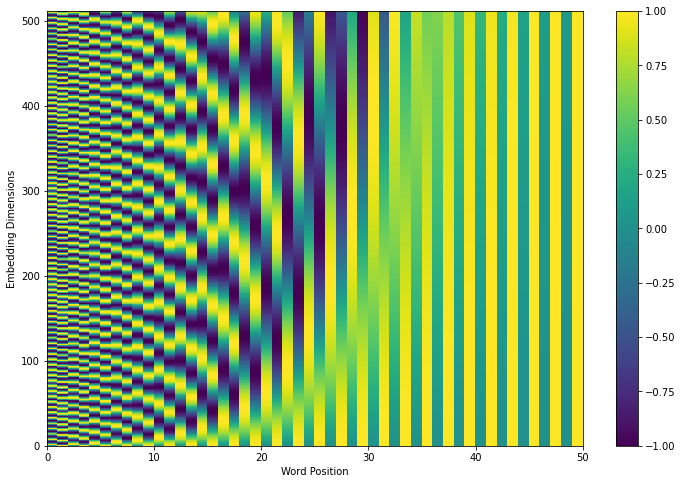

In [97]:
sentence_length = 50
dimensions = 512
pe = PositionalEncoding(sentence_length, 0, 5000)
x = Variable(torch.zeros(1, dimensions, sentence_length))
y = pe.forward(x)
plt.figure(figsize=(12, 8))
plt.pcolormesh(y[0], cmap='viridis')
plt.ylabel('Embedding Dimensions')
plt.ylim((0, dimensions))
plt.xlim((0,sentence_length))
plt.xlabel('Word Position')
plt.colorbar()
plt.show()


## 4 Why Self-Attention

Here, the authors motivate why they chose to investigate Self-Attention in place of recurrence. As the authors point out, there are three different reasons:
1. The first is the total computational complexity per layer, which is shown in the paper to be $O(n^2\cdot d)$ for the Self-Attention layer, compared to $O(n\cdot d^2)$ for a recurrent layer or $O(k\cdot n\cdot d^2)$ for a convolutional layer, where $n$ is sequence length, $d$ is the representation dimension and $k$ is the kernel size of convolutions. Therefore, when the sequence length $n$ is smaller than the representation dimensionality $d$, the self-attention layer is faster. This is almost always the case with sentence representations used in most tasks.
2. The amount of parallelization is another concern. Convolutional layers and self-attention layers both have complete parallelization, in that the computation time does not scale at all with increasing sequence length $n$. However, recurrent layers scale linearly with $n$, therefore they are much slower to compute as they cannot be parallelized.
3. Finally, the path length between long-range dependencies in the network should also be measured. Learning these long-range dependencies is a major challenge that affects performance of the network, and longer paths between dependencies makes learning them that much harder. This is one of the places where the true genius of the model shows, as not only is it faster and more parallelizable, the path length between dependencies does not scale with sequence length $n$, making learning these long range dependencies very easy compared to a recurrent network, which has a maximum path length that scales linearly with sequence length.

## 5 Training

### 5.1 Training Data and Batching

For this model, the authors trained on the WMT 2014 English-German dataset with 4.5 million sentence pairs. Byte-pair encoding was used, with 37000 shared source tokens. For English-French, the larger WMT 2014 English-French dataset with 36 million sentences was used. Sentence pairs are batched by approzimate sequence length. Each training batch contained a set of sentence pairs containing approximately 25000 source tokens and 25000 target tokens.

### 5.2 Hardware and Schedule

8 NVIDIA P100 GPUs were used for training. The base model, using hyperparameters described throughout the paper was trained for 100,000 steps at about 0.4 seconds per step, or 12 hours. For the author's larger models (described elsewhere in the paper), they were trained for 300,00 steps at about 1.0 seconds per step, or 3.5 days.

### 5.3 Optimizer

The authors used the Adam Optimizer with hyperparameters $\beta_1=0.9,\beta_2=0.98$ and $\epsilon=10^{-9}$. The learning rate was varied over the course of training according to this formula:
<br>
<center>$lrate=d^{-0.5}_{\text{model}}\cdot \text{min}(step\_num^{-0.5},step\_num\cdot warmup\_steps^{-1.5})$</center>
<br>
In the author's words, "this corresponds to increasing the learning rate linearly for the first $warmup\_steps$ training steps, and decreasing it thereafter proportionally to the inverse square root of the step number." The authors ued $warmup\_steps=4000$.

### 5.4 Regularization

The authors used three types of regularization during training:

**Residual Dropout:** Dropout is applied to the output of each sub-layer before it is added to the sub-layer input (during the _residual connections_). Dropout is also applied to the sums of the embeddings and positional encodings when entering both the encoder and decoder stacks. For the base model, they use a dropout rate of $P_{drop}=0.1$.

**Label Smoothing:** During training, they also used label smoothing with a rate of $\epsilon_{ls}=0.1$. The authors note that this helps improve accuracy and BLEU score at the cost of perplexity.

## 6 Results

To read the results of the paper, you should read the original paper, linked at the beginning of this page. There, they will go over results in incredible depth, with well organized tables.

## 7 Conclusion

Suffice it to say that the introduction of this model shifted the entire field of Natural Language Processing into a new direction. Variations of this model are state-of-the-art to this day, and don't seem to be going anywhere anytime soon, at least not until the next milestone model breaks onto the scene. Many very-hyped-up model, such as OpenAI's GPT series (on GPT-3 as of the time of writing) and other Language Models use Transformers in some way or another and Machine Translation almost exclusively uses Transformers. Learning the ins and outs of how they work and why they work is an undertaking, but important if you wish to be at the forefront of the field. For the code from the original paper, visit their github [here](https://github.com/tensorflow/tensor2tensor). For more reading on newer variants, I suggest reading Transformer-XL model [here](https://arxiv.org/abs/1901.02860) or the BERT model [here](https://arxiv.org/abs/1810.04805). If you are looking for something similar to this document for those papers, I plan to eventually cover those as well. Check out my github [here](https://github.com/jacobhutchinson) to see if those are available.